##*performing Long Short Term Memory(LSTM) Model to predict Energy Usage*


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# import csv files from google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# read the file 500_buildings in google drive

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/proc/500_buildings.csv')


In [4]:
df.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
0,2016-02-29 09:00:00,1076,148.4476,0,2,0,9,12,3,17433.0,16.7
1,2016-02-29 10:00:00,1076,235.0420,0,2,0,10,12,3,17433.0,21.1
2,2016-02-29 11:00:00,1076,272.1539,0,2,0,11,12,3,17433.0,21.7
3,2016-02-29 12:00:00,1076,296.8952,0,2,0,12,12,3,17433.0,22.2
4,2016-02-29 13:00:00,1076,346.3777,0,2,0,13,12,3,17433.0,23.9


In [5]:
df['meter'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [6]:
# prompt:  filter only the building_id number 183 and 211 and 239

df_filter = df[df['building_id'].isin([183, 211, 239])]


In [7]:
df_filter.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqm,airTemperature
949906,2016-01-01 00:00:00,183,0.0000,0,1,4,0,2,3,7954.6,9.4
949907,2016-01-01 01:00:00,183,157.9424,0,1,4,1,2,3,7954.6,8.9
949908,2016-01-01 02:00:00,183,160.7869,0,1,4,2,2,3,7954.6,8.9
949909,2016-01-01 03:00:00,183,156.2107,0,1,4,3,2,3,7954.6,8.3
949910,2016-01-01 04:00:00,183,157.6949,0,1,4,4,2,3,7954.6,7.8


In [8]:
# prompt: filter only the meter type 0 and show

df_filter = df_filter[df_filter['meter'] == 0]


In [9]:
df_filter['meter'].unique()


array([0])

In [10]:
# prompt: remove the columns  	month	weekday	hour		primaryspaceusage

df_filter.drop(['month', 'weekday', 'hour', 'primaryspaceusage'], axis=1, inplace=True)


In [11]:
# prompt: show the data

df_filter.head()


,timestamp,building_id,meter_reading,meter,site_id,sqm,airTemperature
949906,2016-01-01 00:00:00,183,0.0000,0,2,7954.6,9.4
949907,2016-01-01 01:00:00,183,157.9424,0,2,7954.6,8.9
949908,2016-01-01 02:00:00,183,160.7869,0,2,7954.6,8.9
949909,2016-01-01 03:00:00,183,156.2107,0,2,7954.6,8.3
949910,2016-01-01 04:00:00,183,157.6949,0,2,7954.6,7.8


In [12]:
# prompt: remove meter column

df_filter.drop(['meter'], axis=1, inplace=True)


In [13]:
# prompt: clean the data

df_filter.fillna(method='ffill')
df_filter.fillna(method='bfill')
df_filter.isnull().sum()


timestamp         0
building_id       0
meter_reading     0
site_id           0
sqm               0
airTemperature    0
dtype: int64

In [14]:
# prompt: split the data to be training < 2017-1-1 00:00:00 and testing >2017-1-1 00:00:00

# splitting the data

train = df_filter[df_filter['timestamp'] < '2017-1-1 00:00:00']
test = df_filter[df_filter['timestamp'] >= '2017-1-1 00:00:00']


In [15]:
pd.DataFrame(test)

,timestamp,building_id,meter_reading,site_id,sqm,airTemperature
965235,2017-10-01 00:00:00,183,562.0127,2,7954.6,19.4
965236,2017-10-01 01:00:00,183,555.8283,2,7954.6,18.9
965237,2017-10-01 02:00:00,183,544.9443,2,7954.6,18.9
965238,2017-10-01 03:00:00,183,538.7603,2,7954.6,17.8
965239,2017-10-01 04:00:00,183,508.9529,2,7954.6,17.8
...,...,...,...,...,...,...
1019014,2017-12-31 19:00:00,211,1.2369,2,4160.6,-1.1
1019015,2017-12-31 20:00:00,211,1.2369,2,4160.6,-1.1
1019016,2017-12-31 21:00:00,211,1.2369,2,4160.6,-1.7
1019017,2017-12-31 22:00:00,211,1.2369,2,4160.6,-2.2


In [16]:
train_datetime = train['timestamp']
test_datetime = test['timestamp']

In [17]:
train = train.drop(columns=['timestamp'])
test = test.drop(columns=['timestamp'])

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [19]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [20]:
features = ['site_id', 'sqm', 'airTemperature']
target = 'meter_reading'

In [71]:
train_features = train_scaled[:, [0] + list(range(2, train_scaled.shape[1]))]
train_target = train_scaled[:, 1]
test_features = test_scaled[:, [0] + list(range(2, train_scaled.shape[1]))]
test_target = test_scaled[:, 1]

In [74]:

# LSTM model with 50 hidden units
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# using the adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# training the model
model.fit(train_features, train_target, epochs=100, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

# evaluating the model
model.evaluate(test_features, test_target)

# making predictions
predictions_scaled = model.predict(test_features)


Epoch 1/100
1125/1125 [==============================] - 17s 10ms/step - loss: 6.3286e-04 - val_loss: 0.0014
Epoch 2/100
1125/1125 [==============================] - 11s 10ms/step - loss: 5.0475e-04 - val_loss: 0.0011
Epoch 3/100
1125/1125 [==============================] - 10s 9ms/step - loss: 4.9993e-04 - val_loss: 0.0015
Epoch 4/100
1125/1125 [==============================] - 10s 9ms/step - loss: 4.9432e-04 - val_loss: 0.0012
Epoch 5/100
1125/1125 [==============================] - 10s 8ms/step - loss: 4.9387e-04 - val_loss: 0.0011
Epoch 6/100
1125/1125 [==============================] - 10s 9ms/step - loss: 4.9208e-04 - val_loss: 0.0013
Epoch 7/100
207/207 [==============================] - 2s 3ms/step


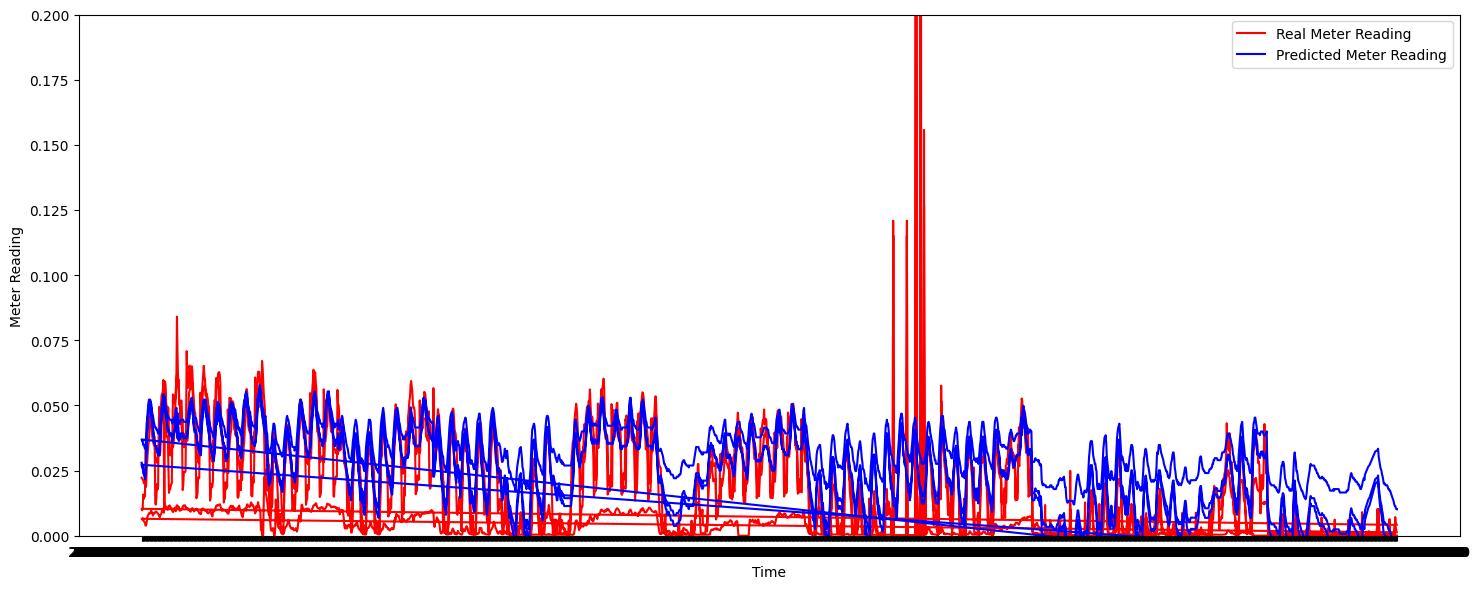

In [99]:
predictions = predictions_scaled.ravel().reshape(-1, 1)



# Plotting the results with a wider plot and improved layout
plt.figure(figsize=(15, 6))
plt.plot(test_datetime, test_target, color='red', label='Real Meter Reading')
plt.plot(test_datetime, predictions, color='blue', label='Predicted Meter Reading')
plt.xlabel('Time')
plt.ylabel('Meter Reading')
plt.ylim([0, 0.2])
plt.legend()
plt.tight_layout()
plt.show()